In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().home()/"code"/"XAI"/"models"))
sys.path.append(str(Path().home()/"code"/"XAI"/"models"/"relavance"))
sys.path.append(str(Path().home()/"code"/"XAI"/"models"/"mnist"))

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from models.deconv.deconvnet import deconvMNIST
from models.relavance.lrp import lrpMNIST
from models.reshape import Reshape
from models.relavance.layers import relConv2d, relLinear, relMaxPool2d, relReLU
from models.saliency.saliency import saliencyMNIST
from models.mnist.MnistModels import MNISTmodel
from models.mnist.MnistTrain import build_dataset

In [2]:
activation_types = ["relu", "tanh", "sigmoid", "softplus"]
model_types = ["dnn", "cnn"]
args = dict(
    root = Path().home()/"code"/"data",
    project_path = Path().home()/"code"/"XAI",
    logterm = False, 
    sv_folder = "mnist", 
    n_step = 20,
    batch_size = 128,
    download = False,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    seed = 73
)
_, test_dataset, *_ = build_dataset(str(args["root"]), 1)

In [3]:
from collections import defaultdict
torch.manual_seed(74)

imgs_dict = defaultdict(list)

for img, t in zip(test_dataset.data, test_dataset.targets):
    imgs_dict[t.item()].append(img.float())

for k, v in imgs_dict.items():
    imgs_dict[k] = torch.stack(v)

def get_samples(cat, sample_size=1, idx=None):
    assert cat == "all" or isinstance(cat, int), "cat should be 'all' or int type"
    if cat == "all":
        temp = []
        for i in range(10):
            img_len = len(imgs_dict[i])
            idx = torch.randint(0, img_len, size=(sample_size, ))
            imgs = imgs_dict[i][idx].unsqueeze(1)
            temp.append(imgs)
        samples = torch.cat(temp)
        labels = torch.arange(10)
    else:
        if idx is None:
            idx = torch.randint(0, len(imgs_dict[cat]), size=(sample_size, ))
        else:
            idx = torch.LongTensor([idx])
        samples = imgs_dict[cat][idx].unsqueeze(1)
        labels = torch.LongTensor([cat])
    # Preprocessing
    samples = (samples - 0.5) / 0.5
    return samples, labels

# 5: 162 --> get wrong answer 
imgs, labels = get_samples(cat="all", sample_size=1)

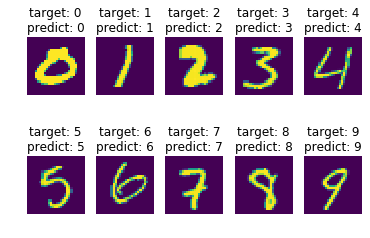

In [4]:
model_type = "cnn"
activation_type = "relu"
model = MNISTmodel(model_type, activation_type)
load_path = f"./trained/mnist/{model_type}-{activation_type}.pt"
model.load_state_dict(torch.load(load_path, map_location="cpu"))

def model_predict(model, samples):
    model.eval()
    outputs = model(samples, store=True)
    preds = outputs.argmax(1)
    return preds

preds = model_predict(model, imgs)
fig, axes = plt.subplots(2, 5)

for ax, pred, img, label in zip(axes.flatten(), preds, imgs, labels):
    title = f"target: {label.item()}\npredict: {pred.item()}"
    ax.imshow(img.squeeze()*0.5+0.5)
    ax.set_title(title)
    ax.axis("off")
# plt.tight_layout()
plt.show()

In [5]:
def draw_actmap(tensor, title, labels=None, vis_row=2, vis_channel=4, return_fig=False):
    """
    vis_row: related with batch
    vis_channel: related with channel
    """
    tensor = tensor.detach()
    B, C, H, W = tensor.size()
    if C == 1:
        fig_h, fig_w = (4*B, 4)
        a, b = (1, 1)
    else:
        fig_h, fig_w = ((C//vis_channel)*B, vis_channel*B)
        a, b = (vis_channel, C//vis_channel)
    
    fig = plt.figure(figsize=(fig_h, fig_w))
    
    o_grid = gridspec.GridSpec(vis_row, B//vis_row, wspace=0.2, hspace=0.2)
    for k, o_g in enumerate(o_grid):
        ax = fig.add_subplot(o_g)
        if labels is not None:
            t = title + f"\ntarget={labels[k]}"
        else:
            t = title
        ax.set_title(t, fontsize=20)
        ax.axis("off")

        i_grid = gridspec.GridSpecFromSubplotSpec(a, b,
                subplot_spec=o_g, wspace=0.05, hspace=0.05)

        axes = []
        for i, img in enumerate(tensor[k]):
            ax = fig.add_subplot(i_grid[i])
            im = ax.imshow(img, cmap="coolwarm")
            ax.axis("off")
            axes += [ax]
        fig.colorbar(im, ax=axes, orientation='vertical')
    plt.show()
    if return_fig:
        return fig

## Activation Maps

In [6]:
model.activation_maps.keys()

odict_keys(['(0) Conv2d', '(3) Conv2d', '(7) Linear'])

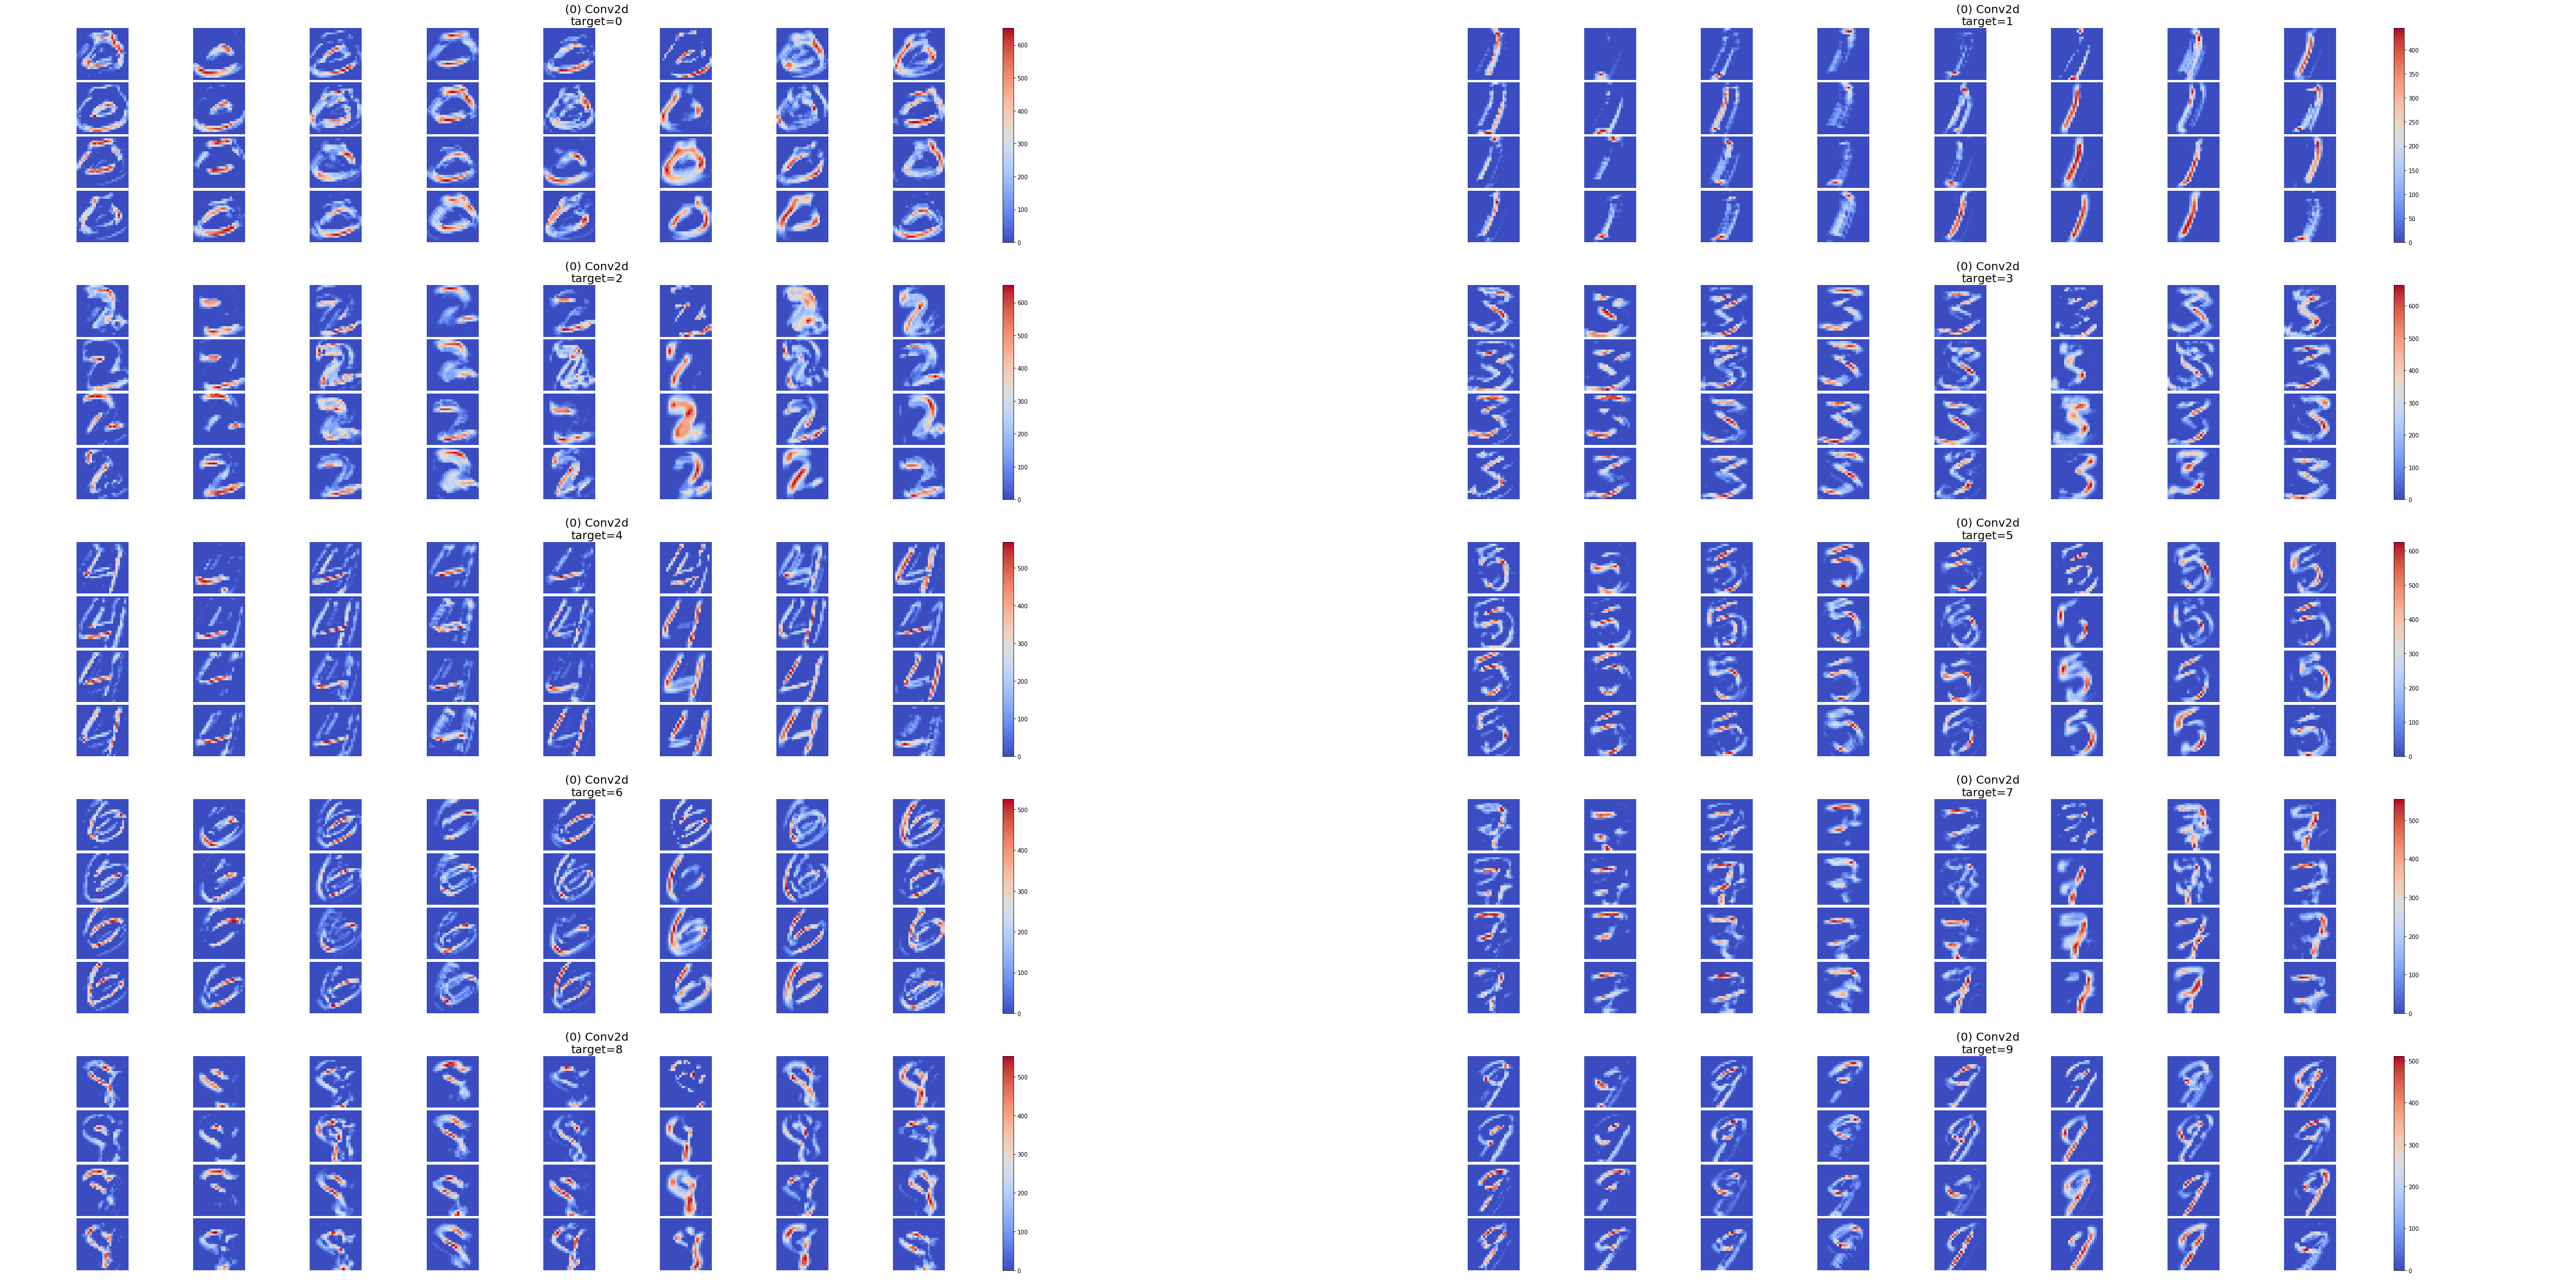

In [7]:
layer_name = "(0) Conv2d"
act_map = model.activation_maps[layer_name]
draw_actmap(act_map, layer_name, labels=labels, vis_row=5, vis_channel=4)

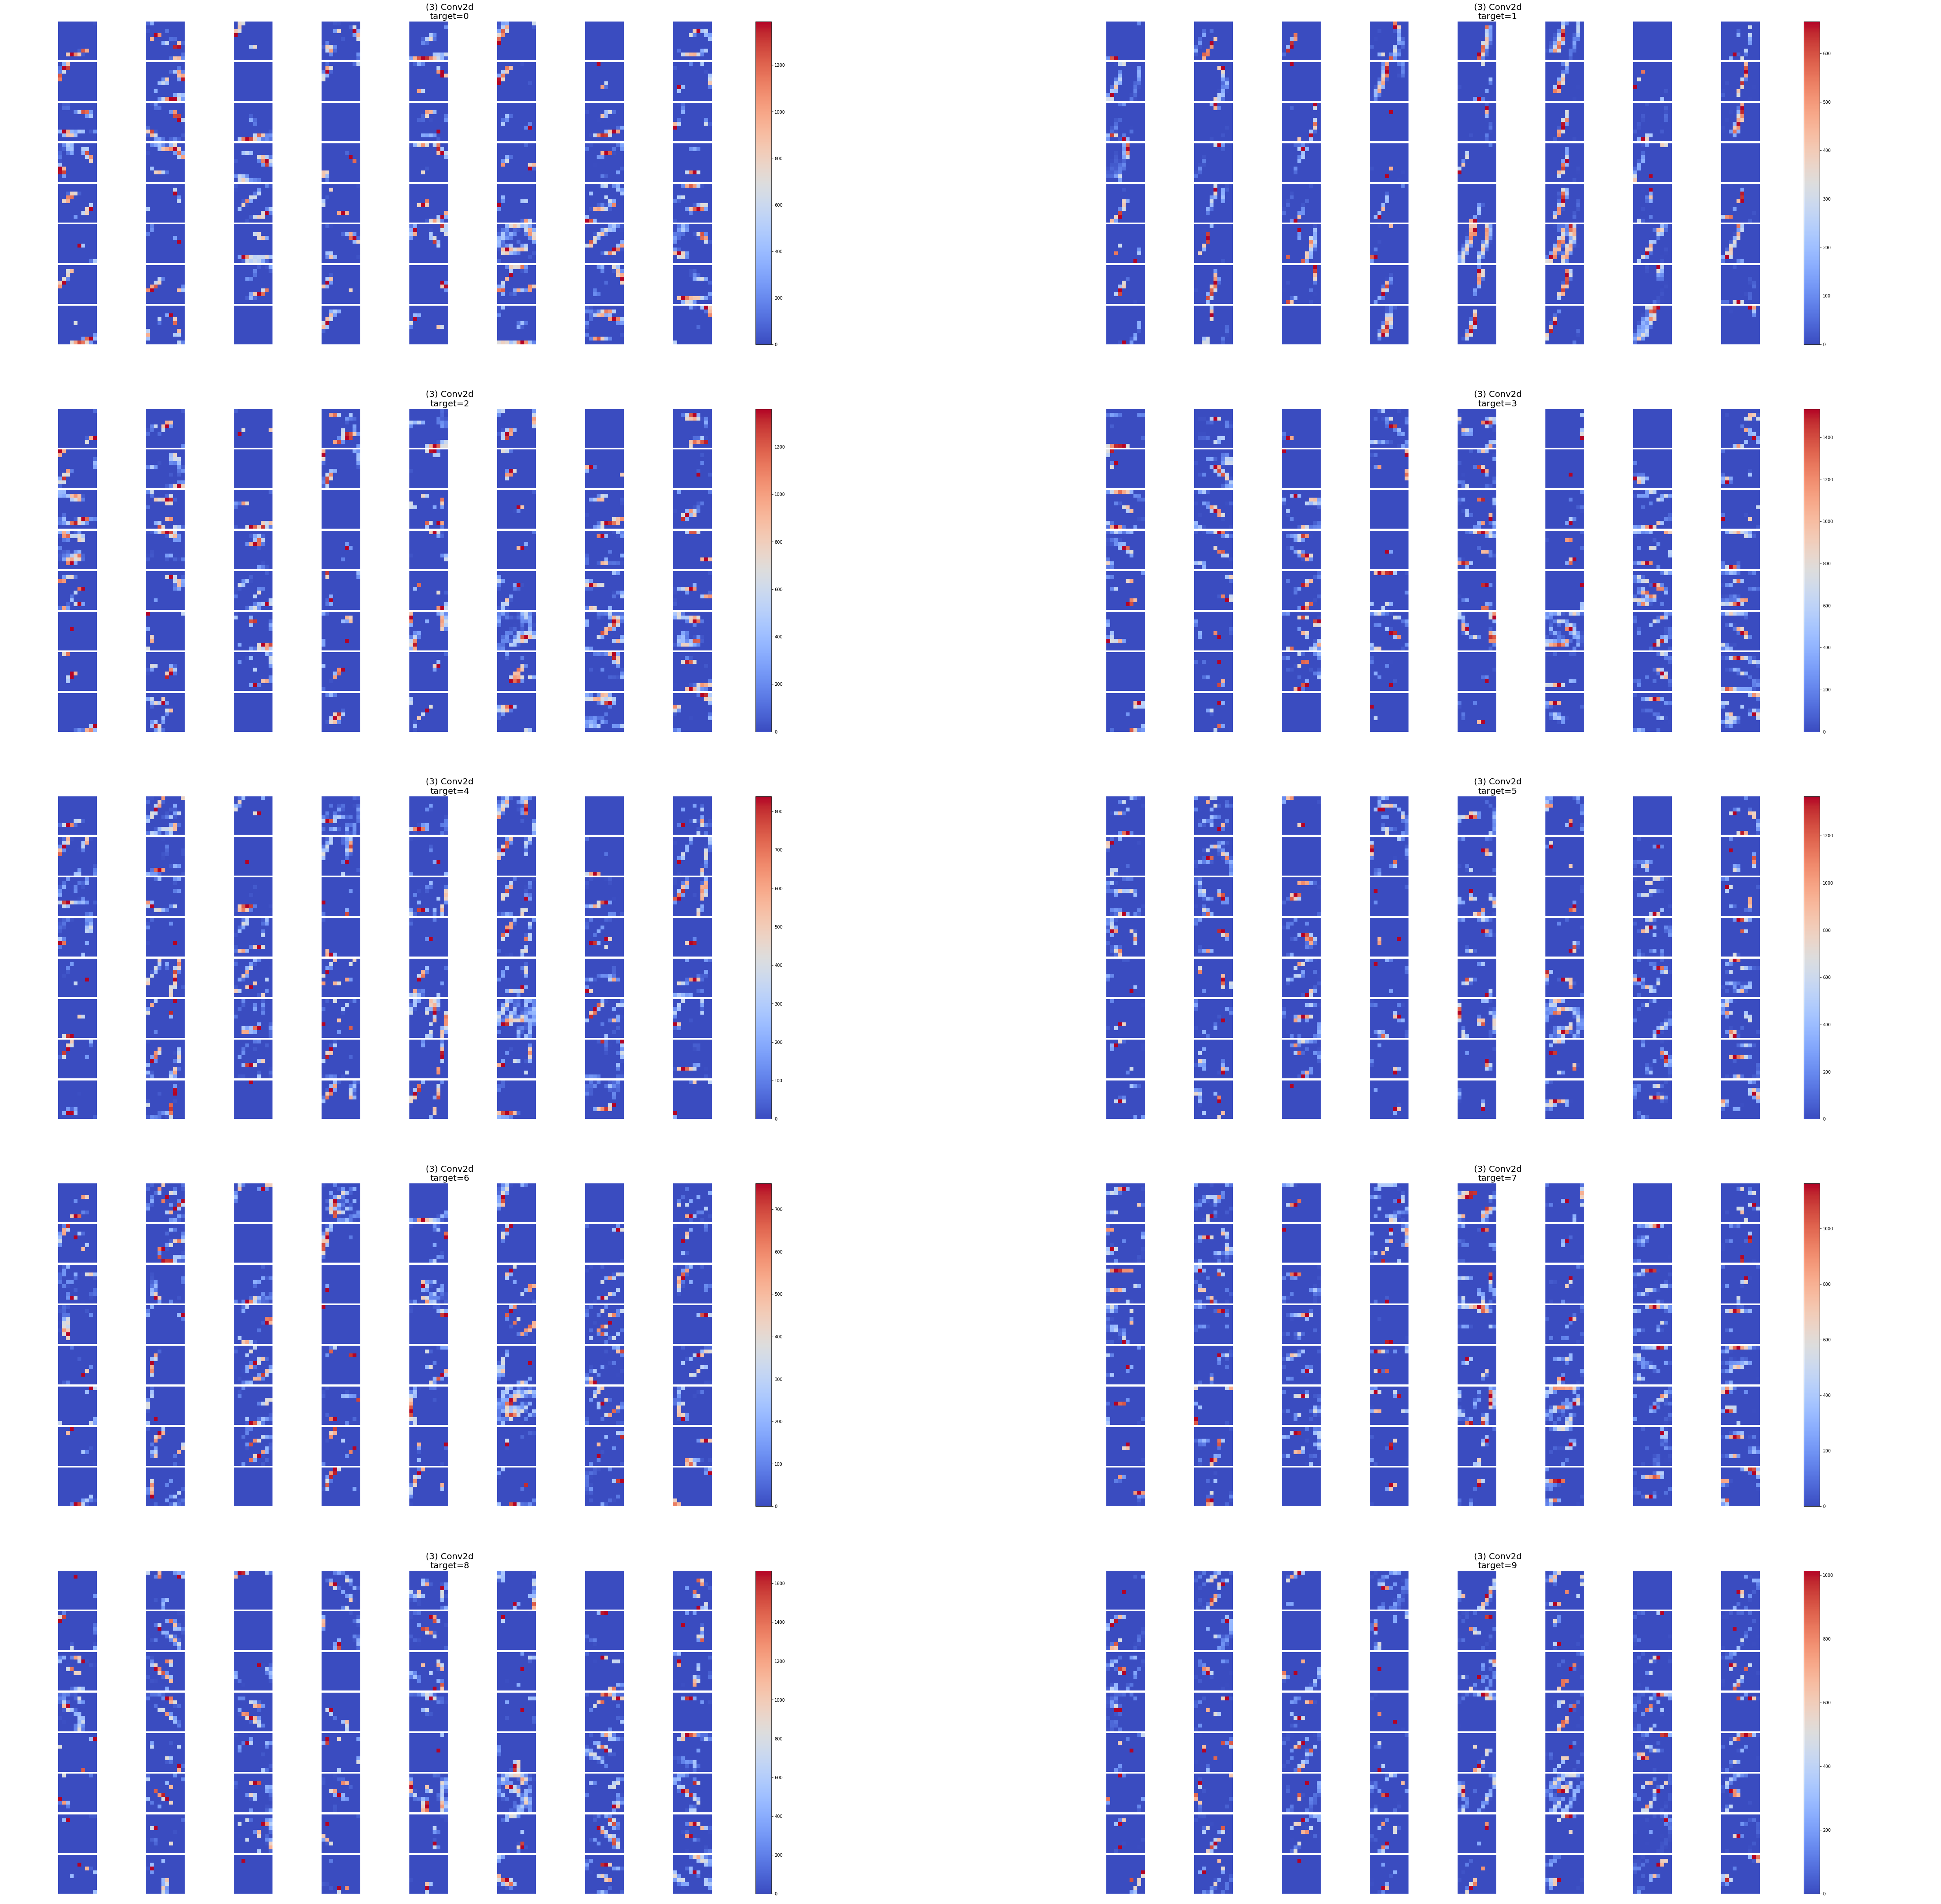

In [11]:
layer_name = "(3) Conv2d"
act_map = model.activation_maps[layer_name]
draw_actmap(act_map, layer_name, labels=labels, vis_row=5, vis_channel=8)

## Deconvnet

In [100]:
layers = []
for idx, layer in enumerate(model.layers[:conv_start]):
    if isinstance(layer, nn.Conv2d):
        temp_layer = nn.ConvTranspose2d(layer.out_channels,
                                        layer.in_channels,
                                        layer.kernel_size, 
                                        layer.stride, 
                                        layer.padding,
                                        layer.output_padding,
                                        layer.groups, 
                                        False,  # bias
                                        layer.dilation,
                                        layer.padding_mode)
        temp_layer.weight.data = layer.weight.data
        layers.append(temp_layer)
    elif isinstance(layer, nn.MaxPool2d):
        temp_layer = nn.MaxUnpool2d(layer.kernel_size,
                                    layer.stride,
                                    layer.padding)
        layers.append(temp_layer)
    else:
        layers.append(layer)
# layers = nn.Sequential(*reversed(layers))
layers = nn.Sequential(*layers)

layers

Sequential(
  (0): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (1): ReLU()
  (2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (4): ReLU()
  (5): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
)

In [94]:
model.layers[:conv_start]

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
model.layers[:conv_start][]

In [99]:
for idx, layer in enumerate(layers):
    if conv_pos.get(idx):
        idx2 = len(layers) - 1 - conv_pos[idx]
        print(idx, idx2, layer)

0 2 MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
3 -994 MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))


In [96]:
i = len(layers) - 1 - conv_pos[0]
i

2

In [90]:
conv_pos = {}
conv_locs = [i for i, l in enumerate(model.layers[:conv_start]) if isinstance(l, nn.Conv2d)]
for idx, i in enumerate(conv_locs):
    if idx == (len(conv_locs) - 1):
        conv_pos[i] = 999
    else:
        j = len(model.layers[:conv_start]) - conv_locs[idx+1]
        conv_pos[i] = j 

In [ ]:
temp_layer.weight.data = layer.weight.data
f_bias = model.layers[:conv_start][idx].bias.data
        

In [68]:
temp_layer.bias

In [75]:
model.layers[:conv_start][0].bias.size()

torch.Size([32])

In [51]:
conv_pos = {}  # {deconv : conv}
conv_start = [i for i, l in enumerate(model.layers) if str(l) == "Reshape()"][0]


In [7]:
layers = []
        
conv_pos = {}  # {deconv : conv}
conv_locs = [i for i, l in enumerate(model.layers) if isinstance(l, nn.Conv2d)]
conv_start = [i for i, l in enumerate(model.layers) if str(l) == "Reshape()"][0]
add = len(model.layers) - conv_start
# [0, 3]
# {6: 0, 999: 3}
for idx, i in enumerate(conv_locs):
    if idx == (len(conv_locs) - 1):
        conv_pos[i] = 999
    else:
        j = len(model.layers) - conv_locs[idx+1] -1
        conv_pos[i] = j 
conv_pos_reverse = {v: k for k, v in conv_pos.items()}

for idx, layer in enumerate(model.layers[:conv_start][::-1]):        
    if isinstance(layer, nn.Conv2d):
        temp_layer = nn.ConvTranspose2d(layer.out_channels,
                                        layer.in_channels,
                                        layer.kernel_size, 
                                        layer.stride, 
                                        layer.padding,
                                        layer.output_padding,
                                        layer.groups, 
                                        False,  # bias
                                        layer.dilation,
                                        layer.padding_mode)
        temp_layer.weight.data = layer.weight.data
        # add bias to previous layer, 
        # cannot add last conv layer, size doesn't match
        check_idx = len(model.layers) - 1 - idx
        if conv_pos_reverse[check_idx] != 999:  # if it is not last conv
            temp_layer.bias.data = model.layers[conv_pos[check_idx]]
        layers.append(temp_layer)
    elif isinstance(layer, nn.MaxPool2d):
        temp_layer = nn.MaxUnpool2d(layer.kernel_size,
                                    layer.stride,
                                    layer.padding)
        layers.append(temp_layer)
    else:
        layers.append(layer)

In [8]:
conv_pos

{6: 0, 999: 3}

In [9]:
conv_pos_reverse

{0: 6, 3: 999}

In [16]:
list(enumerate(model.layers[::-1]))

[(0, Linear(in_features=128, out_features=10, bias=True)),
 (1, ReLU()),
 (2, Linear(in_features=1600, out_features=128, bias=True)),
 (3, Reshape()),
 (4,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (5, ReLU()),
 (6, Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))),
 (7,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (8, ReLU()),
 (9, Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1)))]

In [6]:
# deconv
model = MNISTmodel(model_type, activation_type)
deconv_model = deconvMNIST(model, load_path)
deconv_outputs = deconv_model.deconv(imgs, store=True)
vis_layers = {k: v for k, v in deconv_model.activation_maps.items() if "Linear" not in k}
vis_layers.keys()

KeyError: 0

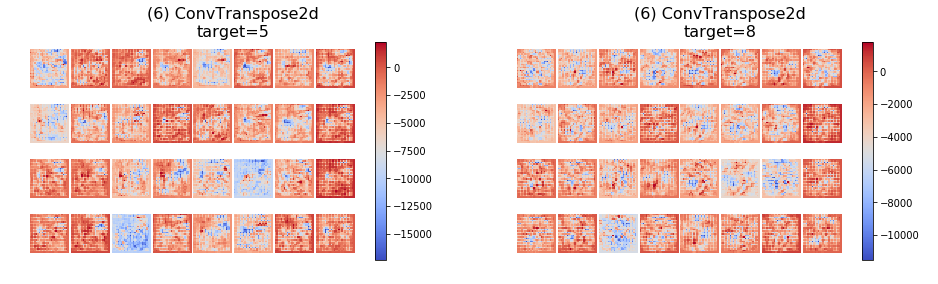

In [16]:
layer_name = "(6) ConvTranspose2d"
draw_actmap(vis_layers[layer_name], layer_name, labels=[5, 8])

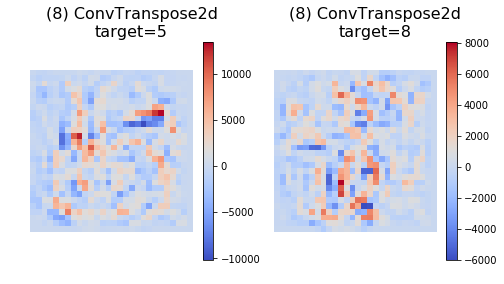

In [17]:
layer_name = "(8) ConvTranspose2d"  # == deconv_output
draw_actmap(vis_layers[layer_name], layer_name, labels=[5, 8])

In [18]:
output_5 = deconv_outputs[0].view(1, -1).detach()
output_8 = deconv_outputs[1].view(1, -1).detach()
torch.cosine_similarity(output_5, output_8)

tensor([0.1278])

## LRP

In [19]:
def draw_attribution(tensor, title, labels=None):
    tensor = tensor.detach()
    B, C, H, W = tensor.size()
    fig, axes = plt.subplots(1, B, figsize=(6*B, 6))
    if B == 1:
        axes = [axes]
    for k, ax in enumerate(axes):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.imshow(tensor[k].squeeze(), cmap="coolwarm")
        fig.colorbar(im, cax=cax, orientation='vertical')
        if labels is not None:
            t = title + f"\ntarget={labels[k]}"
        else:
            t = title
        ax.set_title(t, fontsize=16)
    plt.tight_layout()
    plt.show()

In [20]:
# lrp
model = MNISTmodel(model_type, activation_type)
lrp_model = lrpMNIST(model, load_path)
lrp_outputs = lrp_model.relprop(imgs, store=True, use_rho=True)

### Input = (5, 8), Predict = 8  

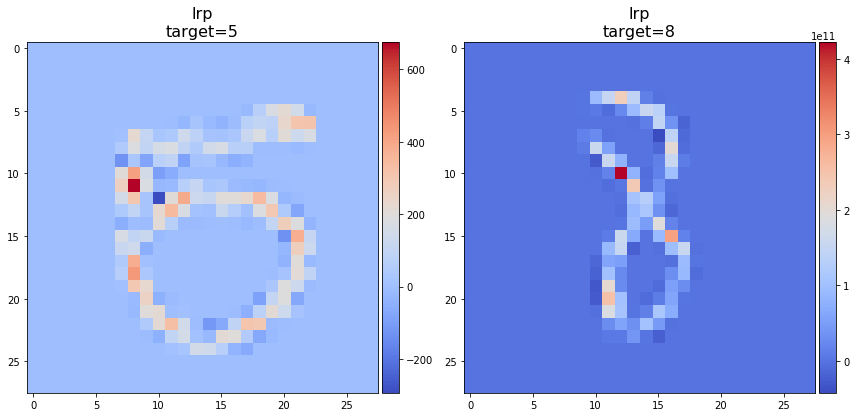

In [23]:
draw_attribution(lrp_outputs, "lrp", labels=[5, 8])

## Saliency

In [24]:
model = MNISTmodel(model_type, activation_type)
saliency_model = saliencyMNIST(model, load_path)
saliency_outputs = saliency_model.generate_saliency(imgs, labels)

### Input = (5, 8), Predict = 8  

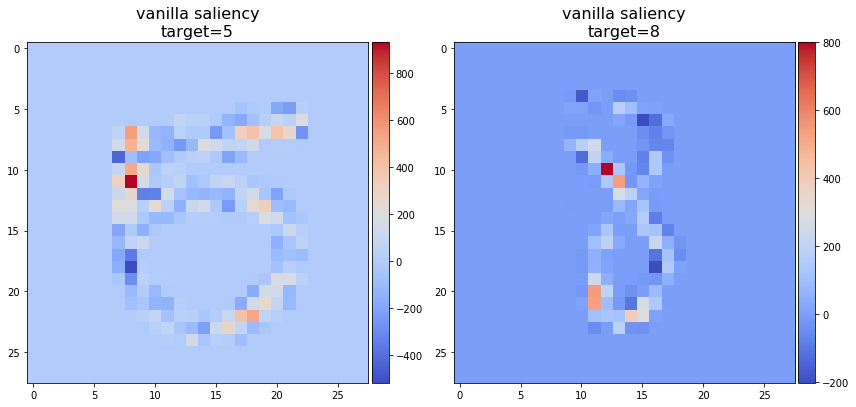

In [25]:
draw_attribution(saliency_outputs, "vanilla saliency", labels=[5, 8])